# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 0, # None; 0; int >= 1
        
        'function_generation_type': 'distribtion',# 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 100,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 100,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets100_var10_class2_distribtion_xMax1_xMin0_xDistuniform_randParamDist_maxDistClass0_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets100_var10_class2_distribtion_xMax1_xMin0_xDistuniform_randParamDist_maxDistClass0_depth4_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [None]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [None]*number_of_trained_lambda_nets

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.001,0.004,0.003,0.064,0.000,0.000,0.000,0.000,0.000
2,0.000,0.015,0.004,0.004,0.073,0.000,0.007,0.000,0.000,0.000
3,0.000,0.019,0.004,0.005,0.082,0.000,0.009,0.000,0.000,0.000
4,0.000,0.034,0.005,0.005,0.099,0.001,0.011,0.000,0.000,0.000
5,0.000,0.042,0.006,0.006,0.104,0.001,0.013,0.000,0.000,0.000
6,0.000,0.044,0.006,0.007,0.105,0.002,0.014,0.000,0.000,0.000
7,0.000,0.057,0.006,0.008,0.108,0.002,0.016,0.000,0.000,0.000
8,0.000,0.065,0.006,0.008,0.116,0.002,0.017,0.000,0.000,0.000
9,0.000,0.066,0.006,0.008,0.116,0.002,0.017,0.000,0.000,0.000


In [13]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


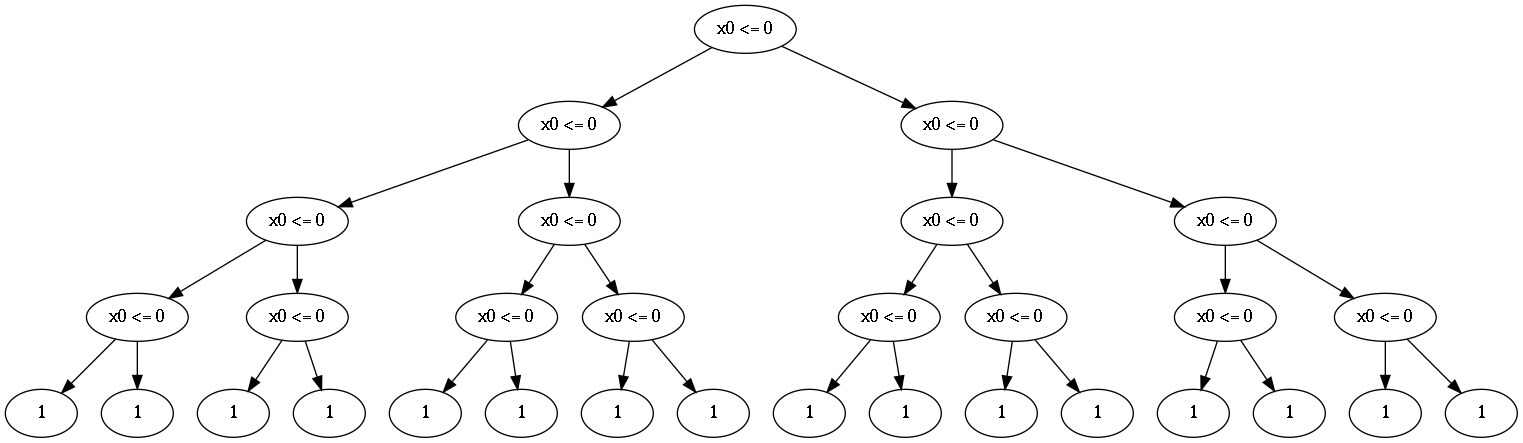

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [19]:
y_data_list[0][0]

feat0      0
feat1      0
feat2      0
feat3      0
feat4      0
feat5      0
feat6      0
feat7      0
feat8      0
feat9      0
feat10     0
feat11     0
feat12     0
feat13     0
feat14     0
split0     0
split1     0
split2     0
split3     0
split4     0
split5     0
split6     0
split7     0
split8     0
split9     0
split10    0
split11    0
split12    0
split13    0
split14    0
lp0        0
lp1        0
lp2        0
lp3        0
lp4        0
lp5        0
lp6        0
lp7        0
lp8        0
lp9        0
lp10       0
lp11       0
lp12       0
lp13       0
lp14       0
lp15       0
dtype: int64

In [20]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

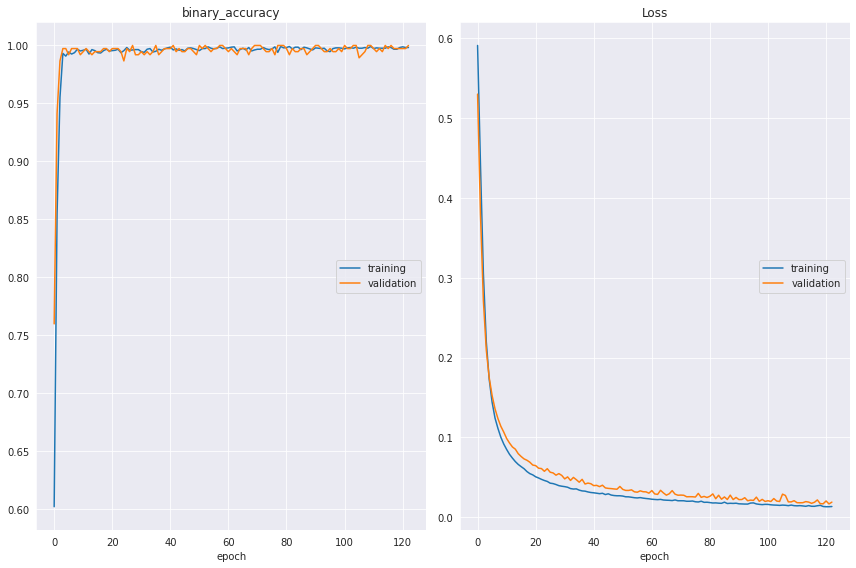

binary_accuracy
	training         	 (min:    0.602, max:    0.999, cur:    0.998)
	validation       	 (min:    0.760, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.013, max:    0.591, cur:    0.013)
	validation       	 (min:    0.017, max:    0.530, cur:    0.019)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()],
                                  return_model=True,
                                  printing=False)

In [24]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1], 
                                              return_model=True,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list[:10], y_data_list[:10], distribution_parameter_list_list[:10])))  
del parallel

[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_514347/1277643394.py", line 3, in <module>
    clf_list = parallel(delayed(train_lambda_net)(config=config,
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/joblib/parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/smar

TypeError: object of type 'NoneType' has no len()

In [ ]:
model_list = [clf['model'] for clf in clf_list]

In [ ]:
generate_data_distribtion(config, 
                          seed=RANDOM_SEED+i, 
                          max_distributions_per_class=max_distributions_per_class, 
                          random_parameters=random_parameters_distribution,
                          flip_percentage=0) 

In [ ]:
z

In [ ]:
shaped_network_parameters_to_array(model_list[0].get_weights(), config)

In [ ]:
np.random.seed(42)
np.count_nonzero(np.round(model_list[0].predict(np.random.uniform(0,1,(100,10)))))

In [ ]:
line_array= np.array([0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.007871077, 0.019227676, 0.06049267, -0.11096079, -0.10718311, 0.07268503, 0.070552185, -0.020789566, -0.17641541, -0.1865493, 0.17409845, -0.11240931, 0.067920685, -0.01773455, 0.1190652, 0.09628576, 0.13399908, -0.098537944, -0.006490561, -0.071188256, -0.11238956, 0.008158254, -0.0008007571, -0.0026006792, 0.13049957, 0.04704446, 0.04051142, 0.106938936, -0.041266188, 0.06370939, -0.0822466, 0.14959574, 0.18709098, 0.067184806, -0.07721369, 0.11085195, 0.007599116, 0.17280468, 0.015853273, -0.0918726, 0.04111024, 0.060455233, 0.1153687, 0.16261484, 0.19679408, 0.12281814, 0.1451466, -0.21911578, 0.11625098, -0.21983118, 0.13927664, -0.12836641, -0.058468543, -0.10890538, 0.054522183, 0.117795095, 0.0024565738, 0.017654316, -0.11986976, 0.13142247, 0.017072072, 0.1373946, -0.17703144, 0.2267174, -0.02286977, -0.00060769875, 0.12724438, 0.03272676, -0.070347734, 0.027505355, 0.041767158, 0.1564854, 0.024579216, -0.030077063, -0.0041587194, 0.012980198, 0.041061502, 0.00013621151, 0.15839812, -0.14059499, 0.05837339, -0.019385708, -0.14156361, 0.07191339, 0.03772232, -0.070279665, -0.16690727, 0.016912162, -0.001966942, 0.12652817, 0.11989795, -0.17914312, -0.11790955, -0.022793192, 0.04077262, 0.028248115, -0.032827504, 0.09718628, 0.0849416, -0.021449834, -0.23735163, -0.19581753, -0.1004676, -0.102348946, 0.1156424, 0.043808766, 0.11508226, 0.12746923, -0.19217545, 0.053634223, 0.064405665, 0.0056435666, -0.007966063, 0.1679317, 0.006177048, -0.16352531, -0.01191753, 0.06348253, 0.11688323, 0.14446078, -0.0015151011, 0.17554791, 0.021768965, 0.08975485, -0.16161072, 0.090057276, 0.020613175, 0.0092701465, -0.30352312, 0.49953508, 0.42336768, -0.31022725, -0.3892227, 0.390593, -0.15273938, -0.1108775, 0.0071481797, -0.19900766, 0.39181164, 0.021874085, -0.25869715, -0.30313385, 0.2677292, -0.21719512, -0.2989725, -0.072879694, 0.471995, -0.24914153, -0.13842484, -0.14251247, 0.4224318, 0.32115492, 0.30870867, 0.38401407, -0.2608726, 0.11260246, -0.1934413, -0.013713956, 0.0002245009, 0.13879974, -0.11057055, 0.07811426, -0.19365339, 0.37030998, 0.031875707, 0.38555917, -0.16070157, -0.27222145, 0.40934405, -0.08958136, -0.16415302, 0.17511891, 0.31075248, -0.12696123, 0.17139933, -0.16474639, 0.11809852, -0.05238329, 0.44287366, -0.19978815, -0.23430097, -0.17206492, -0.34144768, 0.34249917, 0.33538988, -0.378247, 0.03082317, 0.19575132, -0.10526062, -0.14419115, -0.034268346, 0.2160429, 0.33952108, -0.27807444, -0.31726897, 0.4241455, -0.12625019, -0.13191666, -0.2821006, 0.18631347, 0.37642324, -0.22336797, 0.25801134, -0.03547625, -0.06536234, -0.14514971, 0.35904166, -0.0010592043, -0.12614115, -0.21957119, 0.16688131, -0.06414169, 0.44483003, 0.30935967, 0.020162404, 0.33256686, -0.014864718, -0.35546985, 0.12211383, -0.3221093, 0.17772757, 0.4228428, 0.2377208, 0.33721462, -0.18961462, 0.23125322, -0.12525734, -0.103172384, -0.118357964, -0.07234985, 0.002727689, -0.20450838, 0.27952823, -0.07587662, 0.34810144, 0.29091123, -0.20580734, -0.30220228, -0.01650843, -0.09531647, 0.015930789, 0.2694911, 0.45555523, -0.1897381, -0.2861206, -0.20669325, 0.1934728, -0.15559193, 0.34787223, 0.23259455, -0.08221071, -0.37596223, 0.101683185, -0.15999815, 0.16519615, 0.47884887, -0.014814721, 0.24556129, 0.18573704, -0.1478698, 0.008465527, 0.074187115, -0.1353889, -0.22372647, -0.2230231, -0.07078323, 0.120521106, -0.05571127, -0.26109028, -0.11622941, 0.20763378, -0.20554434, -0.3096181, 0.03492502, 0.43932292, -0.07538579, -0.27200618, -0.33813655, 0.25336683, 0.3952597, 0.36599642, 0.23857018, -0.13063991, 0.29589835, -0.30730924, 0.039743047, 0.051081195, 0.2385905, -0.16478324, 0.3117249, 0.035872117, 0.32990125, -0.19197184, 0.18196636, 0.10640143, -0.22629628, 0.3097431, -0.040220857, -0.09239051, 0.1591236, 0.098098725, -0.13037966, 0.2713738, 0.032405652, 0.39574274, -0.16857497, 0.02296291, -0.15410991, -0.3094557, -0.08011678, -0.09316099, 0.10484554, 0.29709116, -0.02210826, -0.0670681, 0.25860777, -0.22742535, -0.1789542, 0.1702468, 0.31283006, 0.3187883, -0.16159903, -0.3592867, 0.11853624, -0.24240182, -0.21856233, -0.11880722, 0.36858037, 0.35891634, -0.0705147, 0.34095564, -0.19302866, -0.3637652, -0.13866068, 0.17233083, -0.18207934, -0.33032125, -0.07137449, -0.0673259, -0.08833603, 0.10555374, 0.12054195, -0.033411674, 0.0913395, -0.15626845, -0.23707771, 0.20381056, 0.08625668, 0.028537532, 0.38169318, 0.3487822, 0.14009725, -0.16818616, -0.0056021586, -0.24446031, -0.2980826, 0.16739048, -0.14030287, -0.03874173, -0.11065038, 0.2972769, -0.2338234, 0.13387977, 0.36412314, 0.048172537, -0.27878127, 0.0071058273, -0.33714446, -0.1578866, 0.28382036, 0.2252166, -0.09310623, -0.28015122, -0.07516079, 0.22767493, -0.10104237, 0.33757666, 0.21451195, -0.00483699, -0.07180983, -0.16135316, -0.063366614, 0.29308686, 0.34106895, 0.09625685, 0.021868905, 0.15621497, -0.029110413, 0.014329957, 0.0017687066, 0.059514955, 0.13889167, 0.07445261, -0.19815561, 0.041946713, 0.14598854, 0.17462826, 0.14807555, -0.04451618, -0.06557294, 0.1274413, -0.14127225, 0.13390633, -0.051522803, -0.1364412, 0.19124004, 0.17238931, 0.10843641, 0.009337269, -0.040572837, 0.16515395, 0.19263041, 0.2143759, 0.18883379, -0.17985047, 0.15669614, -0.02569528, 0.17040974, -0.15653217, 0.10559601, 0.114288874, 0.0043279673, -0.091871485, 0.13544472, 0.1004489, -0.13717741, 0.10112994, 0.2303202, 0.07568248, 0.16380803, -0.06491465, -0.0994009, 0.078097105, 0.15519415, 0.17593622, -0.12656653, 0.05785677, -0.091412075, 0.2512043, -0.14674309, 0.07291127, -0.028790401, -0.15136051, -0.0018950785, -0.09904276, -0.11605653, -0.005508696, -0.072446294, 0.07300982, -0.0655074, -0.090970345, -0.052230816, 0.2058967, -0.1130041, 0.2150688, 0.02528084, 0.0108233765, 0.033064645, 0.14367455, -0.09773458, -0.1314341, -0.034454137, 0.17196433, -0.12495491, 0.1692957, 0.14335164, 0.18072046, -0.031496014, 0.05527721, 0.1016116, 0.012351673, -0.049038224, 0.0011109433, 0.24415952, -0.06433642, -0.06620935, -0.16602857, -0.15328433, 0.054226387, -0.053601444, 0.09880129, 0.11264761, -0.007696856, 0.04896298, 0.14651479, 0.101429746, -0.10705595, -0.112417065, -0.16785727, -0.13484062, -0.070547596, -0.029468343, 0.045365706, 0.26256266, -0.14766994, 0.106657326, -0.19210167, 0.018879816, 0.22904271, 0.19679005, 0.27405924, -0.10397815, 0.02846367, -0.16281876, -0.18034708, 0.13784267, -0.031939104, -0.058382113, -0.012738217, -0.20438293, -0.045350246, 0.12086947, 0.010466461, 0.26186222, 0.049066, 0.09131006, 0.05161221, 0.013473819, -0.17681846, -0.11070124, 0.18159983, 0.1553465, 0.023406904, 0.069226846, 0.14230473, -0.081753105, 0.079242095, -0.07639612, 0.07991114, -0.10725252, 0.18879753, -0.050967146, -0.034986038, -0.07335137, 0.10735564, 0.15969492, -0.09847334, 0.11905405, -0.058101505, 0.11922684, 0.08172684, -0.058905136, -0.034107625, 0.16509521, -0.06810261, 0.05772968, 0.11790107, 0.19479524, 0.13165021, 0.064271845, -0.05673659, 0.18432713, 0.059725855, -0.04204445, -0.19182393, 0.061813235, 0.23140149, 0.053777434, 0.15006799, 0.176139, 0.06795814, -0.18549122, -0.042584307, -0.16832818, 0.008074746, -0.046845928, 0.1825007, 0.14632551, 0.12986104, 0.022734053, -0.05198059, -0.09550403, 0.20897748, 0.033437494, 0.08701157, 0.14403048, -0.16145587, -0.072680905, 0.09240894, -0.020545846, -0.11133559, -0.1111482, -0.12374194, -0.12799676, -0.13825181, 0.0889915, 0.22583856, 0.09578516, 0.088880815, 0.17717622, -0.04861504, -0.0018509477, -0.07509862, 0.013539459, -0.10655531, 0.056349237, 0.04508106, 0.018543921, 0.06933872, -0.14760086, 0.10645531, 0.11815474, 0.16306636, 0.10492815, -0.22587478, 0.23034368, 0.064719684, 0.13089383, 0.06534126, 0.19602472, 0.13735168, 0.18686622, 0.14163351, 0.0029898286, 0.032103207, 0.05770509, 0.17447852, 0.080944315, 0.04851789, 0.08677946, -0.109530956, -0.087732695, -0.14533952, -0.083479, -0.08505611, 0.18590978, 0.11381827, -0.14197044, -0.033894055, 0.029068764, 0.24424647, -0.013043836, 0.08091626, 0.25901982, 0.14058386, 0.08612038, 0.08429917, -0.1696898, 0.27220076, 0.08909441, -0.17993669, 0.17118467, 0.05418854, -0.026205823, 0.017932475, 0.12857407, -0.12019603, -0.015176976, -0.0053270394, -0.12385733, 0.046545748, -0.033096448, 0.005191861, 0.15565026, 0.08612923, 0.044149082, 0.1093722, 0.0077874847, -0.0085084895, 0.019816348, 0.009820028, 0.016603827, 0.22221112, 0.24879642, -0.0038776798, 0.26360768, -0.13290007, -0.037614025, 0.07081027, 0.030839056, -0.088027716, 0.008937762, 0.11827572, 0.2420974, 0.004595533, 0.016840713, -0.07115221, 0.08292164, -0.0072080274, -0.019336417, 0.28003046, -0.025974872, -0.060318872, 0.014170936, 0.21444988, -0.15932208, 0.11188878, 0.11001826, 0.19143035, 0.16807759, -0.021977432, -0.17252253, 0.14892629, -0.090426154, -0.16018656, 0.26690242, -0.10326239, -0.08761551, -0.12198414, 0.0076642376, -0.019764965, -0.0009966954, 0.051722433, 0.18645757, 0.033106796, -0.0057363417, -0.050609548, 0.24313086, 0.14605287, -0.041108128, 0.057024077, 0.17700309, 0.25380018, -0.012226614, 0.24172129, 0.0880531, -0.087306045, -0.091677845, -0.06485268, -0.18851757, 0.1480521, 0.04595549, -0.013302801, 0.08688145, 0.008395773, -0.096542545, 0.07633283, -0.030755894, 0.13947676, 0.121427976, 0.25018996, 0.081633955, 0.16249152, 0.24485195, -0.05739245, -0.02831523, -0.23136172, -0.006509015, 0.09361789, -0.0046715164, -0.05609032, -0.19631898, -0.19635525, -0.17977655, -0.10411098, 0.033137888, 0.1317089, 0.002577253, 0.08974745, -0.04834733, -0.0016946346, 0.08347548, 0.09905205, -0.09749967, 0.18380585, -0.0472718, 0.12691835, 0.07334689, 0.09149724, -0.019268587, 0.052145194, 0.06358921, -0.06417766, -0.057762858, 0.1869877, 0.1612592, 0.28850132, 0.07466439, 0.15462092, 0.02438618, -0.05642112, 0.08891926, 0.10323305, 0.21919028, -0.034399763, -0.061099354, -0.0010887815, -0.12707171, 0.027346237, -0.19590586, 0.061204605, 0.1987879, -0.08988387, 0.061665293, -0.016664617, 0.1987179, 0.029582636, 0.1766175, 0.17626937, -0.0030355803, 0.06936649, 0.120009854, 0.100971535, 0.1375362, 0.18965167, 0.07782789, 0.070075184, 0.13096382, -0.1446045, 0.20203523, -0.20837337, 0.059055015, -0.13063768, -0.07830471, -0.09360885, 0.067010455, -0.05105674, 0.044698864, 0.07107023, -0.16020183, -0.11266754, -0.007580943, 0.13141258, -0.13635932, 0.1848922, -0.1725322, -0.010890716, 0.034329306, 0.053932093, -0.04982999, 0.25334388, -0.15739067, -0.09973761, 0.08661999, 0.02544293, 0.26409858, 0.06437679, 0.18470089, 0.0927777, -0.027217994, 0.025117217, -0.06064197, 0.16100751, 0.20398392, 0.19612111, 0.0004923756, 0.08221615, -0.115631685, 0.07140536, -0.12885752, -0.106475346, -0.02867939, 0.16755171, -0.07686224, 0.10726089, -0.11976167, 0.10348964, 0.035952166, 0.06074107, -0.12311991, -0.21008344, -0.120352365, 0.23959629, 0.21313888, -0.205865, 0.18741095, 0.07297274, -0.07983194, 0.026401905, 0.18466926, -0.090126485, 0.10341249, 0.043675825, 0.165424, 0.16088775, 0.17809264, 0.11079492, 0.19645911, -0.09784563, 0.14385314, -0.110948525, -0.16112034, 0.08612441, -0.14839783, 0.09981187, -0.08249592, 0.17774022, 0.21810669, -0.039312303, 0.02978724, 0.15550292, 0.030343963, 0.23645885, -0.045137312, 0.24444659, 0.12600034, -0.041845553, -0.07631412, -0.13207227, 0.04369354, 0.20963109, 0.14318791, 0.088326395, 0.12975743, 0.2360278, -0.06619708, 0.38946483, -0.4989176, -0.38234177, 0.5115709, 0.37604702, -0.4762669, 0.14142549, 0.44684187, -0.14968915, -0.18807462, -0.4511508, -0.15160896, 0.52862376, 0.32390118, -0.43568802, 0.058093723, 0.6564938, 0.34331596, -0.4605521, 0.42454016, 0.41003615, 0.4753719, -0.62007594, -0.5169255, -0.50665003, -0.5176643, 0.38348666, -0.5056924, 0.34937793, -0.3876466, -0.015204892, -0.50715065, -0.18436791, -0.21603115, -0.054925993, -0.44266284, 0.02529199, -0.35694793, 0.12283935, 0.44985166, -0.5385432, -0.012277682, 0.09659482, -0.53526175, -0.47524124, -0.110400245, -0.43876162, -0.10387465, -0.43559265, -0.08880396, -0.40026498, -0.040543422, 0.29245582, -0.032446444, 0.4989824, -0.34025908, -0.111024685, 0.38538367, 0.33048078, -0.41003588, 0.5179, 0.0795444, -0.21053275, -0.36272904, -0.30264077, 0.44522616, 0.46890444, -0.43690184, 0.4137268, 0.5491098, 0.5202729, -0.23227741, -0.19444162, 0.418296, -0.57184047, 0.56150144, 0.4911773, 0.024452925, -0.21235807, -0.10508787, 0.54599625, 0.50120944, -0.026027475, 0.040892225, -0.6260107, -0.3853026, -0.02902546, -0.23417279, 0.48547226, 0.43619695, -0.08731356, 0.09905629, -0.078518756, -0.4092585, -0.32556656, -0.57242566, 0.48225257, -0.17513694, 0.52305466, 0.36313888, -0.17144156, -0.101075076, 0.51743805, -0.16328552, -0.102994576, 0.12666373, -0.40440583, -0.4075718, -0.20887688, 0.34944943, -0.17205423, 0.5140071, -0.087592125, -0.4804152, -0.61524194, -0.056621596, 0.29293245, -0.040424418, -0.4880808, -0.1849604, -0.22082536, -0.48765683, 0.4834033, 0.57654583, -0.20879366, 0.03334256, -0.5949887, -0.6241631, 0.26069376, 0.21571325, 0.18813998, 0.054326616, 0.19362317, 0.061125085, 0.04154612, 0.10498853, 0.12943079, -0.12787624, -0.025156438, 0.0035719723, -0.06555699, 0.051715594, -0.061017044, -0.025523283, 0.23434617, -0.030449519, 0.14111765, 0.18672842, 0.21421339, -0.08307963, 0.19708441, -0.18234979, -0.0718996, 0.15920794, 0.16332032, 0.20250054, -0.07725591, 0.27202827, -0.19482276, 0.19896227, 0.18127821, -0.19172755, 0.10622637, -0.087206356, -0.17269674, -0.013538344, -0.080275856, 0.012367277, 0.02596331, 0.19668414, -0.024359679, 0.108734526, -0.08236964, -0.20699267, 0.19236614, 0.1593631, -0.086823516, -0.0813729, -0.09619749, 0.03892544, 0.16963, -0.12500681, 0.08404111, -0.04226548, -0.07567924, 0.04714807, 0.07619754, 0.19362901, -0.08794031, 0.09876981, 0.071600035, -0.08279087, -0.108360454, -0.08915073, 0.11418556, 0.03606743, 0.22067511, -0.024466984, -0.06342619, 0.071896166, -0.135095, -0.100643955, 0.107140236, -0.02781474, 0.0015611262, -0.12550007, -0.09319511, 0.15437828, 0.10293325, 0.08535767, 0.10855247, -0.1412896, 0.026311545, 0.04517074, -0.023455027, 0.16959709, 0.022885183, 0.13396263, -0.04616181, 0.11598796, -0.2338886, 0.12922919, -0.07171964, 0.1399169, -0.04356024, -0.18340988, 0.03097581, 0.104506515, -0.08909142, -0.05040209, 0.14212738, -0.09737399, 0.05146138, -0.12394753, 0.004641331, 0.2348125, 0.065598674, -0.06637499, -0.08582614, 0.13226035, 0.022797387, 0.18315546, 0.053029448, -0.22585605, -0.017046468, -0.07721263, 0.09921787, 0.087715015, 0.13683449, 0.14131917, 0.14421663, -0.0358358, -0.10147874, -0.17828952, -0.10319447, 0.21353772, -0.15923154, -0.017386941, 0.16257636, 0.10402482, 0.081906624, 0.03646447, -0.035533156, 0.0052351914, 0.04398289, 0.085057035, 0.17767784, -0.08044708, 0.011853037, -0.05073362, 0.3060982, -0.09130199, -0.009605028, -0.06594309, -0.07827292, -0.047369465, 0.08565212, 0.18180953, 0.16511811, 0.16570714, 0.10362823, 0.019713243, -0.15865925, 0.15786298, 0.12004761, 0.1620885, 0.054355666, 0.020672444, -0.023189113, 0.15833512, -0.18060602, 0.0032399078, -0.14762214, 0.025890764, -0.061465066, 0.13045855, 0.046363804, -0.001015053, -0.0079437755, 0.29235485, -0.031425677, 0.08093379, 0.03360283, 0.04732465, 0.114262745, -0.15528911, 0.121308625, 0.12447138, 0.06874314, -0.14580882, 0.1004469, 0.105942085, 0.11378959, -0.12864706, 0.120850645, -0.015317744, -0.10714911, -0.19368775, -0.18472283, 0.025691286, 0.101202115, -0.022217337, 0.1717853, 0.2513944, -0.011272002, 0.13712445, -0.091481686, 0.021991959, 0.04302904, 0.088171184, -0.0061968616, -0.08400181, 0.047936566, -0.19917251, -0.09923144, -0.19498263, -0.09718094, -0.0044559683, -0.1713026, 0.04671625, 0.22381224, 0.0932905, 0.029956933, 0.13598372, -0.17631167, 0.10841466, -0.09645156, 0.15160996, -0.1360192, 0.19456378, 0.06605913, 0.2508685, 0.15271473, 0.1853984, 0.13100596, -0.09137363, -0.048119426, -0.14288406, 0.16318028, 0.14605312, 0.22084276, 0.12931553, 0.024205862, 0.0029581944, -0.21296825, 0.07521542, -0.17144543, 0.012186034, -0.18551473, 0.22541639, -0.0058068717, 0.18444736, 0.05089685, -0.07209696, 0.20033894, -0.017451301, 0.23174396, 0.00468754, -0.08294475, -0.11365923, -0.18384589, -0.20429493, 0.22338033, 0.29087007, 0.11285868, 0.009942386, -0.042538393, 0.08908315, 0.07942789, 0.02366853, -0.032929435, 0.122560136, -0.023870563, 0.0, -0.00053043483, 0.0, 0.106418334, 0.10242399, 0.040305547, -0.015342262, 0.12197116, 0.05673943, -0.03514551, 0.07109293, 0.08772242, 0.09945978, 0.00072307914, -0.04977146, -0.003161441, -0.0006585465, 0.12882574, 0.005400696, 0.11711158, 0.07483741, 0.0, 0.01124783, 0.0, -0.058124684, 0.0, 0.049874928, -0.009947637, -0.041418307, -0.04908125, 0.10040249, -0.006225008, -0.019663528, -0.030263318, 0.046444956, 0.050869543, -0.005764289, -0.027042048, -0.00014777214, 0.017487692, -0.014757284, 0.020183878, 0.0, 0.118815586, 0.0, 0.11211518, -0.025454631, -0.060792543, 0.13800798, 0.054783832, -0.0010049132, 0.116469406, -0.019447647, -0.033962507, 0.038455278, -0.073015995, 0.12754467, 0.11197485, 0.0068214056, 0.07349027, 0.1392722, 0.10596638, -0.014498753, -0.053611647, 0.075236924, 0.0160046, 0.109163634, 0.106954105, 0.0, -0.03625928, 0.0, 0.1141335, 0.10115415, -0.030417241, -0.026031032, 0.017973017, 0.000941981, -0.0055448273, -0.058979273, 0.06923765, 0.15134388, -0.03470455, 0.04662777, -0.029160079, -0.07812168, -0.04704646, 0.019099249, 0.06857949, -0.05262103, 0.038706988, 0.108025275, -0.03303757, 0.0, 0.062024184, 0.0, -0.05593507, -0.034293737, 0.021925531, 0.036497816, -0.0054092538, 0.13102747, 0.0, 0.09496187, -0.00018911537, -0.032431018, 0.010854101, -0.008174097, 0.12919146, -0.021694617, 0.0452483, 0.0, -0.0647767, 0.0366693, 0.06768958, 0.12679115, -0.018415168, -0.036095496, 0.019201232, -0.0008360725, -0.46303126, 0.37351653, 0.4113816, -0.5217839, -0.49018323, 0.48888233, 0.085801974, -0.56544703, -0.14376555, -0.19294713, 0.52635413, -0.11626446, -0.39306432, -0.45203558, 0.541625, 0.10515745, -0.4283768, -0.30569464, 0.35529453, -0.44057122, -0.5238056, -0.43004927, 0.3670971, 0.3498835, 0.46760628, 0.39444846, -0.47789627, 0.5289233, -0.5460589, 0.36135155, -0.08506732, 0.5488644, 0.1935074, 0.23618309, -0.07986179, 0.4936032, 0.010720724, 0.51748174, 0.019167302, -0.5490042, 0.37745404, 0.07481312, 0.13136423, 0.58572966, 0.6184853, 0.12726748, 0.5102137, -0.22271234, 0.5841477, -0.20313157, 0.5393634, -0.13276882, -0.5173247, -0.112640366, -0.39609012, 0.467827, 0.11386538, -0.5063708, -0.29649433, 0.5606476, -0.54515976, 0.15090698, -0.12575446, 0.6049381, 0.20731892, -0.5193003, -0.3692508, 0.43802163, -0.4475535, -0.533956, -0.41781855, 0.48435774, 0.2739291, -0.43448207, 0.4727638, -0.50359565, -0.43774855, 0.00014089048, 0.41459617, -0.1454168, -0.41339362, -0.49955508, -0.10111347, 0.07786992, 0.38994315, 0.22617984, -0.16277301, 0.18687679, -0.3216651, -0.449628, 0.18026507, -0.22435054, -0.06741199, 0.26478583, 0.39676723, 0.44969338, -0.34391844, 0.20988435, -0.18927404, -0.4867847, -0.17683817, -0.20253322, -0.3926885, -0.10585907, 0.22858828, 0.054763626, 0.5424176, 0.48786113, -0.19015123, -0.43868652, 0.06661448, -0.43410078, 0.00094797375, 0.51312417, 0.38620427, -0.21114135, -0.48287404, 0.07288048, 0.5749052, 0.14941517, 0.21887247, 0.54914397, -0.1794206, -0.3896255, -0.1266553, 0.10711582, 0.46150118, 0.3401061, -0.052100863])
line_array


In [ ]:
line_distrib = np.array([0,' poisson', 4.0102355931433324, ' NaN', 4.812282711771999, ' NaN',' binomial', 49.18851711477962, 0.2503516370151786, 59.02622053773555, 0.30042196441821434,' normal', 0.6052952376255275, 0.08485637761245057, 0.726354285150633, 0.10182765313494069,' gamma', 3.0547691371073564, 4.398636606053762, 3.6657229645288276, 3.5189092848430095,' exponential', 4.579696579953673, ' NaN', 5.495635895944408, ' NaN',' exponential', 4.488159106371182, ' NaN', 5.385790927645418,' NaN', ' beta', 4.650740566175658, 3.7588687518283903, 3.7205924529405268, 3.0070950014627122, ' normal', 0.3031546269131786, 0.018439046761285383, 0.2425237015305429, 0.02212685611354246, ' gamma', 2.191195962816965, 4.400431338271998, 1.7529567702535718, 5.280517605926398, ' normal', 0.9304624782877245, 0.8651137396721454, 1.1165549739452696, 0.6920909917377164])
line_distrib

In [ ]:
config['i_net'] = {}
config['i_net']['normalize_lambda_nets'] = False

In [ ]:
#config['evaluation'] = {}
#config['evaluation']['random_evaluation_dataset_distribution'] = 'uniform'


In [ ]:
config['evaluation']['random_evaluation_dataset_size'] = int(np.round(config['data']['lambda_dataset_size']*0.25))

In [ ]:
lambda_net = LambdaNet(line_array, line_distrib, config) #line_distrib


In [ ]:
network_params = lambda_net.network_parameters
network = network_parameters_to_network(network_params, config, base_model=None)
X_data = lambda_net.X_test_lambda
distribution_dict_row = lambda_net.distribution_dict_row

In [ ]:
distribution_dict_row[distribution_dict_row == ' NaN'] = np.nan
distribution_dict_row[distribution_dict_row == ' normal'] = 0
distribution_dict_row[distribution_dict_row == ' uniform'] = 1
distribution_dict_row[distribution_dict_row == ' gamma'] = 2
distribution_dict_row[distribution_dict_row == ' exponential'] = 3
distribution_dict_row[distribution_dict_row == ' beta'] = 4
distribution_dict_row[distribution_dict_row == ' binomial'] = 5
distribution_dict_row[distribution_dict_row == ' poisson'] = 6
distribution_dict_row = distribution_dict_row.astype(np.float32)

In [ ]:
X_data.shape

In [ ]:
distribution_dict_row

In [ ]:
random_evaluation_dataset = generate_dataset_from_distributions_line_tf(number_of_variables_function=config['data']['number_of_variables'], 
                                                       number_of_samples_function=config['evaluation']['random_evaluation_dataset_size'], 
                                                       max_distributions_per_class_function = config['data']['max_distributions_per_class'], 
                                                       seed_function = np.random.randint(1_000_000+1), 
                                                       flip_percentage=0,
                                                       config=config,
                                                       distribution_line_function=distribution_dict_row)

print('random_evaluation_dataset.shape', random_evaluation_dataset.shape)

                                                                        

In [ ]:
np.count_nonzero(np.round(network.predict(random_evaluation_dataset).ravel()))

In [ ]:
np.count_nonzero(np.round(network.predict(random_evaluation_dataset).ravel()))

In [ ]:
self.X_test_lambda, _, _, _ = generate_dataset_from_distributions(distribution_list=['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
                                                                 number_of_variables=config['data']['number_of_variables'], 
                                                                 number_of_samples=int(np.round(config['data']['lambda_dataset_size']*0.25)), 
                                                                 distributions_per_class = config['data']['max_distributions_per_class'], 
                                                                 seed = data_generation_seed, 
                                                                 flip_percentage=0, 
                                                                 random_parameters=config['data']['random_parameters_distribution'])   


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext autoreload
%autoreload 2
network_from_param = LambdaNet(line_array, line_distrib, config).network_parameters #line_distrib
network_from_param

In [ ]:
LambdaNet(line_array, line_distrib, config).distribution_dict_list

In [ ]:
test_network = network_parameters_to_network(network_from_param, config, base_model=None)


In [ ]:
np.count_nonzero(np.round(test_network.predict(X_data_list[1][1].values))) #line_distrib

In [ ]:
np.count_nonzero(np.round(test_network.predict(LambdaNet(line_array, line_distrib, config).X_test_lambda))) #line_distrib

In [ ]:
np.count_nonzero(np.round(test_network.predict(LambdaNet(line_array, line_distrib, config).X_test_lambda))) #line_distrib

In [ ]:
np.count_nonzero(np.round(model_list[0].predict(LambdaNet(line_array, line_distrib, config).X_test_lambda)))#line_distrib

In [ ]:
np.random.seed(42)
np.count_nonzero(np.round(test_network.predict(np.random.uniform(0,1,(10000,10)))))

In [ ]:
np.random.seed(42)
np.count_nonzero(np.round(model_list[0].predict(np.random.uniform(0,1,(100,10)))))

In [ ]:
shaped_network_parameters_to_array(model_list[0].get_weights(), config)

In [25]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:  1.1min remaining:    3.5s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  1.2min finished


In [ ]:
random_network['model'].get_config()

In [ ]:
random_network['model'].summary()

## Save and Plot Lambda-Model History

In [ ]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


In [ ]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [ ]:
loss_df.describe()

In [ ]:
val_loss_df.describe()

In [ ]:
metric_df.describe()

In [ ]:
val_metric_df.describe()

In [ ]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
print('a')